# Spartina Recovery Model
### Christine Angelini & Johan van de Koppel - April 2013

Roughly based on Guichard et at, 2003. Mussel Disturbance Dynamics: Signatures of Oceanographic
Forcing from Local Interactions. Am. Nat. 2003. Vol. 161, pp. 889-904.

Here we model the expansion of vegetation out of 

### First setup of the model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import time,os
from fbm import fbm
from matplotlib.colors import LinearSegmentedColormap

# Putting the screen to full width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

on=1;off=0;           # Declaration of the terms on and off

### Settings of the simulation

In [2]:
# Remaining vegetation patches distribution, being "Random", "Fractal", "Even", "Bare" 
Patches = "Fractal"
Border  = off;

Bare = 1
Patch = 2
Borders = 3

# ----- Model parameters -----------------------------------------------------
Alpha1 =  0.5        #Probability of a bare cell becoming colonized by a border, if a neighboring cell is a border
Alpha2  = 0.7        # Probability of bare cell becoming colonized by a patch, if a neighboring cell is colonized by a patch 

CoverThreshold = 1   # If the cover goes beyond this value, the return time is measured

In [3]:
# Loading the functions that create the fractal and regular patches functions
# source('RandomFractalPatches.r', echo=FALSE)
# source('RegularPatches.r', echo=FALSE)

### Simulation parameters

In [4]:
n       = 256       # Dimensions of the simulated landscape
EndTime = 250       # Number of timesteps in the whole simulation
NoFrames= EndTime   # Number of frames displayed during the entire simulation

### Initialisation

In [5]:
Neighbourhood = np.array([[1, 1, 1],[1, 0, 1],[ 1, 1, 1]]);
NumberNeighbors = sum(Neighbourhood.flatten())

### Creating a random and a regular field

In [6]:
def RegularPatches(N,Cover):
  
    # Calculating the distance between the points (in one dimension)
    Scale=int(1/np.sqrt(Cover)) 
    NP=int(N/(Scale))

    Margin=int((N-Scale*(NP-1))/2)

    Cells=np.zeros((N,N))
    for i in range(Margin,Margin+NP*Scale,Scale):
        for j in range(Margin,Margin+NP*Scale,Scale):
            Cells[i,j]=1
            
    return Cells

In [7]:
def FractalPatches(n,p,c):
    R=fbm(n,p)[0:(n-1),0:(n-1)]
    Rs=np.sort(R.flatten())
    T=Rs[int(n*n*c)+1]
    return (R<T)

In [8]:
FractalField = FractalPatches(n-1,0.01,0.07)
RegularField = RegularPatches(n-1,0.07)

FractalField.shape

(254, 254)

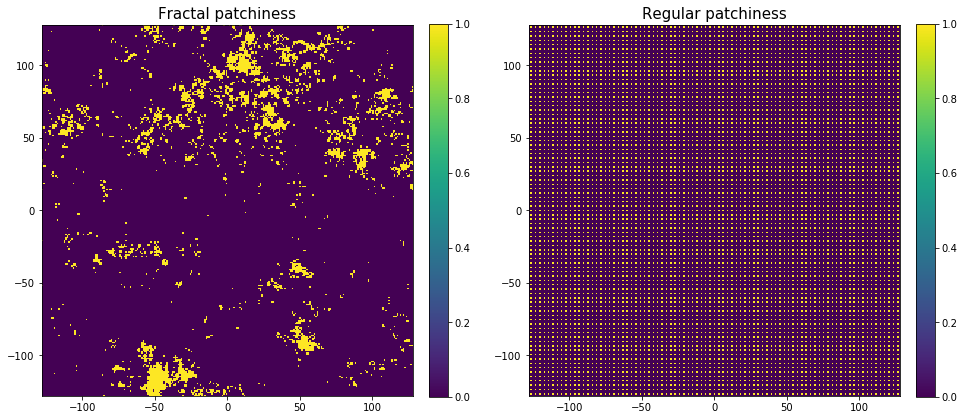

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(16, 10))
im0=ax[0].imshow(FractalField, extent=[-n/2,n/2,-n/2,n/2], clim=[0,1])
ax[0].set_title('Fractal patchiness', fontsize=15)
fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04);

im1=ax[1].imshow(RegularField, extent=[-n/2,n/2,-n/2,n/2], clim=[0,1])
ax[1].set_title('Regular patchiness', fontsize=15)
fig.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04);

In [10]:
# ------------ The simulation loop ---------------------------------------
def RunSim(Cover):
    
    Cells=np.zeros((n,n));            # The matrix holding the cell states (0-1-2)

    # Initializing the Matrix
    if Patches=="Random":  # random number for each cell
        PatchVector = (np.random.random((n-2,n-2))<FractionPatch) + 1 
        Cells[1:(n-1),1:(n-1)] = PatchVector
    elif Patches=="Fractal":  # a fractal field is generated
        Cells[1:(n-1),1:(n-1)] = FractalPatches(n-1,0.01,Cover) + 1
    elif Patches=="Even": # a field of regularly-spaced dots is generated
        Cells[1:(n-1),1:(n-1)] = RegularField + 1
    elif Patches=="Bare":
        Cells[1:(n-1),1:(n-1)] = matrix(ncol=n-2, nrow=n-2)
    
    # if you want a border, then the edges are filled with vegetation (e.g., set to 2)
    if Border==on:
        Cells[0,:]=3
        Cells[n-1,:]=3
        Cells[:,0]=3
        Cells[:,n-1]=3

    # Vector where the cover for each time step is stored
    PatchCover_in_Time = np.empty((EndTime,1))
    BorderCover_in_Time = np.empty((EndTime,1))
    TotalCover_in_Time = np.empty((EndTime,1))

    # Array where the matrix is stored each timestep
    Cells_in_Time = np.zeros((n,n,NoFrames))

    for Counter in range(NoFrames):

        for inter in range(int(EndTime/NoFrames)):
            # SumBorderOccu=matrix(nrow=n,neighbours(x=Cells,state=3,wdist=Neighbourhood))
            SumBorderOccu = signal.convolve2d(Cells==3, Neighbourhood, boundary='symm', mode='same')

            # SumPatchOccu=matrix(nrow=n,neighbors(x=Cells, state=2,wdist=Neighbourhood))
            SumPatchOccu = signal.convolve2d(Cells==2, Neighbourhood, boundary='symm', mode='same')

            NBord=SumBorderOccu/NumberNeighbors  # NBord is the proportion of neighbors that are Borders

            NPatch=SumPatchOccu/NumberNeighbors #NPatch is the proportion of neighborsPatch 

            R=np.random.rand(n,n)

            ColonisationBorder= ((Cells==Bare)&(R<=(NBord*Alpha1))&((NBord*Alpha1)>(NPatch*Alpha2)))*2 
            #I am trying to add 2 here so cell state goes from 1->3, but am not sure if this formula does this

            ColonisationPatch= (Cells==Bare)&(R<=(NPatch*Alpha2))&((NPatch*Alpha2)>(NBord*Alpha1))
            #I want to add 1 so cell state goes from 1->2

            #The clauses after the ampersand at the end of the previous 2 lines are meant to correct cells that may be surrounded by both patch and border cells  

            # Combining it all the calculate the new cell state
            Cells = Cells + ColonisationBorder + ColonisationPatch 

        Area=(n-2)*(n-2)
        Cells_in_Time[:,:,Counter] = Cells;
        PatchCover_in_Time[Counter]  = sum((Cells==2).flatten())/Area # the total numbers of cells that are occupied divided by the area
        BorderCover_in_Time[Counter] = sum((Cells==3).flatten())/Area
        TotalCover_in_Time[Counter]  = (PatchCover_in_Time[Counter]+BorderCover_in_Time[Counter])

    return Cells_in_Time, PatchCover_in_Time, BorderCover_in_Time, TotalCover_in_Time  ;       

### Running the simulation

In [11]:
Cells_in_Time, PatchCover_in_Time, BorderCover_in_Time, TotalCover_in_Time = RunSim(0.01)

### Making a plot

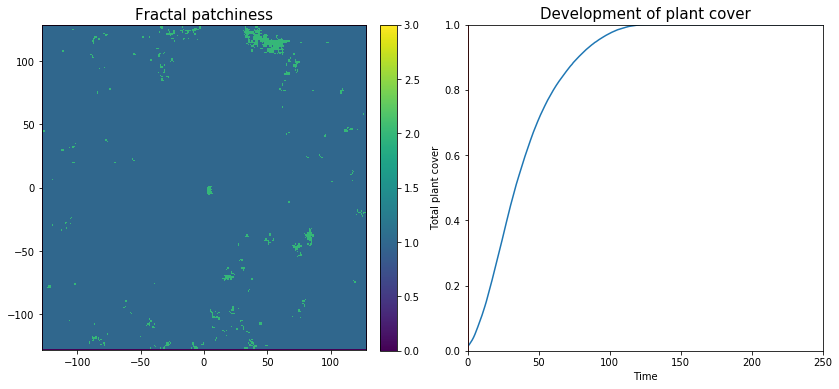

In [12]:
Time=np.linspace(0,EndTime,NoFrames)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
im0=ax[0].imshow(Cells_in_Time[:,:,0], extent=[-n/2,n/2,-n/2,n/2], clim=[0,3])
ax[0].set_title('Fractal patchiness', fontsize=15)
fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04);

pl1=ax[1].plot(Time,TotalCover_in_Time)
ax[1].set_xlim([0,EndTime])
ax[1].set_ylim([0,1])
ax[1].set_title('Development of plant cover', fontsize=15)
ax[1].set_ylabel('Total plant cover');
ax[1].set_xlabel('Time');
Red,=ax[1].plot([0,0],[0,1],'r')

### Making a movie

In [13]:
from matplotlib import animation, rc

def updatefig(i): # To update the image at each iteration
    im0.set_array(Cells_in_Time[:,:,i])
    Red.set_xdata([Time[i],Time[i]])
    #text1.set_text("Time: %1.0f of %1.0f" % ((i+1)/NumFrames*EndTime, EndTime));
    return im1,Red

ani = animation.FuncAnimation(fig, updatefig, interval=100, frames = NoFrames, repeat=False, blit=True)

from IPython.display import HTML
HTML(ani.to_html5_video())

In [14]:
# Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
ani.save('PigMarshes.mp4', writer=writer, dpi=120)

### When recovery was 95% full

In [15]:
RecoveryIndex=np.where(TotalCover_in_Time>0.95)[0][0]
print('Recovery was full at %1.1f' % (RecoveryIndex/NoFrames*EndTime))

Recovery was full at 91.0


In [16]:
def GetRecoveryRate(Cover):
    Cells_in_Time, PatchCover_in_Time, BorderCover_in_Time, TotalCover_in_Time = RunSim(Cover)
    if (len(np.where(TotalCover_in_Time>0.95)[0])==0):
        RecoveryIndex=np.nan
    else:
        RecoveryIndex=np.where(TotalCover_in_Time>0.95)[0][0]
    return RecoveryIndex

### Vegetation recovery as a function of mussel cover
Presuming the maximal cover of the mussels is 20% of the area

In [17]:
Simulate = on
Filename='HogSimulations-large6.npz'

if Simulate==on:
    Cmax=0.1
    Samples=25
    CoverNr=20
    Cover=np.zeros(CoverNr)
    RecReps=np.zeros((CoverNr,Samples))
    Recovery=np.zeros(CoverNr)

    from ipywidgets import FloatProgress
    from IPython.display import display

    Start_Time= time.time() 

    # Setting up a progress bar for the simulation
    print("Progress :");
    PB = FloatProgress(min=0, max=Samples*CoverNr); display(PB) 

    for i in range(CoverNr):
        Cover[i]=Cmax*(i+1)/CoverNr
        for rep in range(Samples):
            RecReps[i,rep]=GetRecoveryRate(Cover[i])
            PB.value += 1    

    os.system("say finished")   

    End_Time= time.time() 
    print('Simulations took : %1.3f' % (End_Time-Start_Time))
    np.savez(Filename, RecReps=RecReps, Cover=Cover)
else:
    Data=RecReps=np.load(Filename)
    Cover=Data['Cover'] 
    RecReps=Data['RecReps'] 
RecReps

Progress :


FloatProgress(value=0.0, max=500.0)

Simulations took : 33638.903


array([[104., 188., 137., 163., 128., 193.,  94., 146., 122., 168., 124.,
        101., 148., 102., 133.,  93., 100., 126., 173., 125., 209., 105.,
        132.,  99., 120.],
       [ 73., 157.,  71.,  61., 175.,  88., 104., 117.,  79., 118., 118.,
         69.,  87.,  61.,  84., 119., 100.,  84., 154.,  83.,  93., 134.,
         86.,  89.,  92.],
       [ 71., 111.,  91., 135.,  58., 113.,  59.,  74.,  84.,  65.,  86.,
         74.,  96.,  64.,  88.,  70., 122.,  90.,  98.,  75.,  88.,  96.,
        102., 139.,  53.],
       [ 70., 107.,  67.,  80., 123.,  61.,  75.,  68.,  80., 112., 103.,
         82.,  60.,  72.,  51.,  73.,  81.,  71., 113.,  75.,  84.,  80.,
         66.,  91.,  49.],
       [ 97.,  64.,  56., 134.,  76.,  97.,  57.,  60.,  43.,  81., 105.,
        121.,  96.,  70.,  73., 124.,  92.,  93.,  50.,  68.,  72.,  80.,
         62.,  57.,  83.],
       [ 50.,  59.,  50.,  55., 118.,  82.,  59.,  54.,  89.,  99.,  50.,
         48.,  45.,  57.,  59.,  78.,  67.,  78.,  

In [18]:
#np.savez('HogSimulations-large.npz', RecReps=RecReps, Cover=Cover)

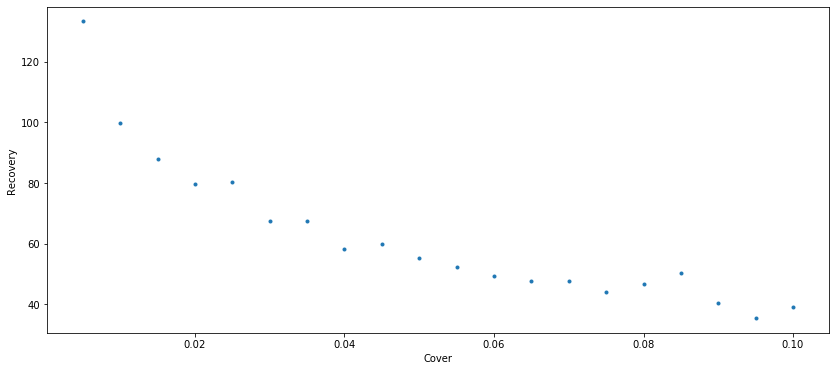

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
ax.set_xlabel('Cover')
ax.set_ylabel('Recovery')
#ax.set_title("Hogs don't focus more on remaining mussels when mussel density diminishes")
ax.plot(Cover,np.mean(RecReps, axis=1),".", label='Recovery');
#ax.set_ylim([0,0.2])


### Effects of Pigs on Mussel patches

Here, we presume that the predation pressure on the mussels increases as the density of mussels down up. We investige 2 models and compare them with the one with a constant predation pressure.

In [20]:
# M(Pt)=(r-d*Pe(Pt))/r*K

Pt=1
r=1
d=0.1
K=100
i=100
a=10
M=np.linspace(1/i,K,i)
Ki=np.linspace(K,K,i)

In [21]:
f1 = Pt/Ki  # A constant predation pressure, no effect of lowered mussel density
f2 = Pt/M  # An increasing predation pressure, going up proportionally as the mussel density decreases
f3 = Pt/(a+M)  # # An increasing predation pressure, going up less than proportionally as the mussel density decreases

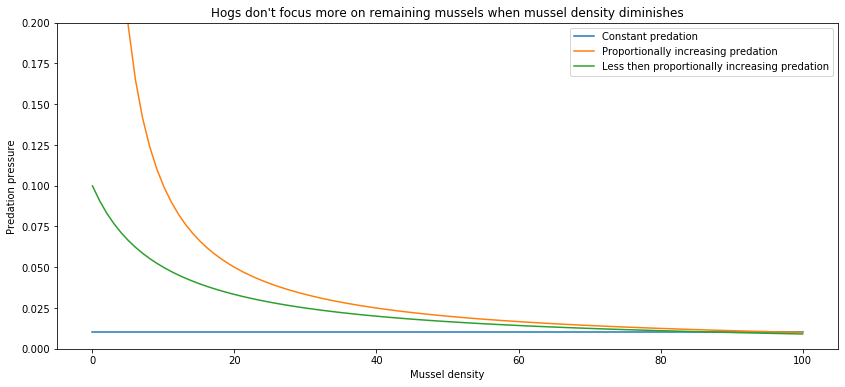

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
ax.set_xlabel('Mussel density')
ax.set_ylabel('Predation pressure')
ax.set_title("Hogs don't focus more on remaining mussels when mussel density diminishes")
ax.plot(M,f1, label='Constant predation');
ax.plot(M,f2, label='Proportionally increasing predation');
ax.plot(M,f3, label='Less then proportionally increasing predation');
ax.set_ylim([0,0.2])
ax.legend();

## Three models of hog predation

### Parameters

In [23]:
r=1    # Growth rate of the mussels
K=100  # Carrying capacity of the mussels
d=10   # Predation parameter linking hog presence to mussel mortality
a=20   # Hog switching parameter, only used in model III

### Model I: No hog focussing
The assumption here is that hogs do not focus on mussels. They only eat them when the accidentaly encounter them.

In [24]:
def f1(M): return 1/K*np.ones(M.shape)
Pt1=r*(1-M/K)/(d*f1(M))

### Model II: Complete focussing
Hogs search for mussels and nothing else. This means that predation pressure increases as mussel density goes down. 

In [25]:
def f2(M): return 1/M
Pt2=r*(1-M/K)/(d*f2(M))

### Model III: Incomplete hog focussing
Hog focussing is there, but is not complete. When mussel density goes down, hogs switch to other food source in part.

In [26]:
def f3(M): return 1/(M+a)
Pt3=r*(1-M/K)/(d*f3(M))

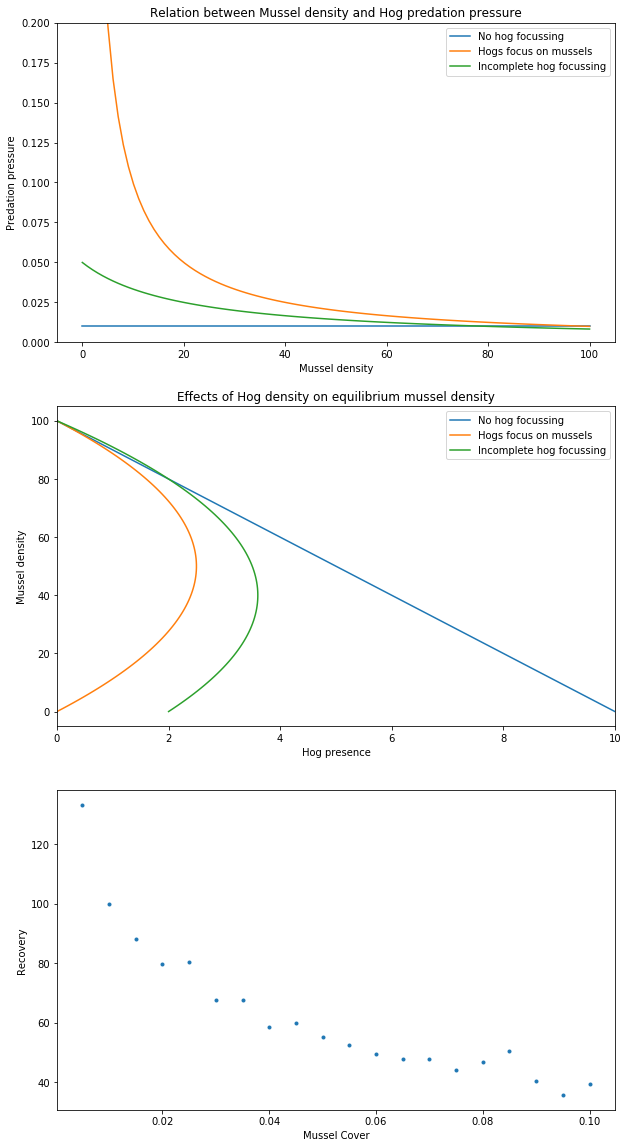

In [27]:
fig, ax = plt.subplots(3, 1, figsize=(10, 20))

ax[0].set_xlabel('Mussel density')
ax[0].set_ylabel('Predation pressure')
ax[0].set_title("Relation between Mussel density and Hog predation pressure")
ax[0].plot(M,f1(M), label='No hog focussing');
ax[0].plot(M,f2(M), label='Hogs focus on mussels');
ax[0].plot(M,f3(M), label='Incomplete hog focussing');
ax[0].set_ylim([0,0.2])
ax[0].legend()

pl1=ax[1].plot(Pt1,M, label="No hog focussing");
pl2=ax[1].plot(Pt2,M, label="Hogs focus on mussels");
pl3=ax[1].plot(Pt3,M, label="Incomplete hog focussing");
ax[1].set_xlim([0,10])
ax[1].set_xlabel('Hog presence')
ax[1].set_ylabel('Mussel density')
ax[1].set_title("Effects of Hog density on equilibrium mussel density")
ax[1].legend();

ax[2].set_xlabel('Mussel Cover')
ax[2].set_ylabel('Recovery')
#ax.set_title("Hogs don't focus more on remaining mussels when mussel density diminishes")
ax[2].plot(Cover,np.mean(RecReps, axis=1),".", label='Recovery');
#ax.set_ylim([0,0.2])

In [ ]:
os.system("say finished");

The End, Johan van de Koppel 2019